# Table of Content

1. [Data Import](#Data-Import)
2. [Exploratory Data Analysis and Feature Extraction](#Exploratory-Data-Analysis-and-Feature-Extraction)
3. [Modeling](#Modeling)
4. [Creating the Submission](#Creating-the-Submission)

## Data Import

In [1]:
#Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 120)

In [3]:
# Read in the csv data
df = pd.read_csv('data/large_train_sample.csv')

In [4]:
# Encoding the target column
df['target'] = df.wage.map(lambda x: 1 if x==' >50K' else 0)
# Dropping the old wage column
df.drop('wage',axis=1,inplace=True)

## Exploratory Data Analysis and Feature Extraction

In [5]:
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  target          32561 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.5+ MB


In [7]:
# An example of the analysis of various categories where a larger proportion of a category was more likely
# to have a high wage
df.groupby('native-country').mean()['target']

native-country
 ?                             0.250429
 Cambodia                      0.368421
 Canada                        0.322314
 China                         0.266667
 Columbia                      0.033898
 Cuba                          0.263158
 Dominican-Republic            0.028571
 Ecuador                       0.142857
 El-Salvador                   0.084906
 England                       0.333333
 France                        0.413793
 Germany                       0.321168
 Greece                        0.275862
 Guatemala                     0.046875
 Haiti                         0.090909
 Holand-Netherlands            0.000000
 Honduras                      0.076923
 Hong                          0.300000
 Hungary                       0.230769
 India                         0.400000
 Iran                          0.418605
 Ireland                       0.208333
 Italy                         0.342466
 Jamaica                       0.123457
 Japan                   

In [8]:
# Baseline score
df[['target']].value_counts(normalize=True)

target
0         0.75919
1         0.24081
dtype: float64

In [9]:
# A function to create features based on the mean normalized value a category has
# in the target column over a certain threshold
def add_binary(df,header,column,threshold):
        scores = df.groupby(df[column]).mean()
        good_status = scores[scores['target'] > threshold].index
        df[header] = df[column].map(lambda x: 1 if x in good_status else 0)
        return print(f'Added {header} column')

In [10]:
# All the features add based on exploratory analysis using .groupby().mean()
add_binary(df,'educated','education',0.24)
add_binary(df,'good_country','native-country',0.25)
add_binary(df,'is_married','marital-status',0.4)
add_binary(df,'is_spouse','relationship',0.4)
add_binary(df,'high_class','workclass',0.25)
add_binary(df,'good_job','occupation',0.25)

Added educated column
Added good_country column
Added is_married column
Added is_spouse column
Added high_class column
Added good_job column


In [11]:
# Features based on participation in the stock market
df['in_market'] = np.where((df['capital-gain'] > 0) | (df['capital-loss'] > 0), 1, 0)
df['has_gains'] = np.where(df['capital-gain'] > 0, 1, 0)
df['has_losses'] = np.where(df['capital-loss'] > 0, 1, 0)
# Features based on time worked
df['over_time'] = np.where(df['hours-per-week'] > 40, 1, 0)
df['part_time'] = np.where(df['hours-per-week'] < 40, 1, 0)
df['higher_ed'] = np.where(df['education-num'] >= 13, 1, 0)
# Age constraints
df['over_20'] = np.where(df['age'] >= 20, 1, 0)
df['over_30'] = np.where(df['age'] >= 30, 1, 0)
df['over_40'] = np.where(df['age'] >= 40, 1, 0)
df['over_50'] = np.where(df['age'] >= 50, 1, 0)
df['over_60'] = np.where(df['age'] >= 60, 1, 0)
df['over_70'] = np.where(df['age'] >= 70, 1, 0)
# Those with very large capital gains
df['high_gains'] = np.where(df['capital-gain'] > 5000, 1, 0)
# Feature to identify that the native country is not the United States
df['immigrant'] = np.where(df['native-country'] != ' United-States', 1, 0)

In [12]:
# Dummifying the categorical data
df_dum = pd.get_dummies(df,columns=df.select_dtypes('object').columns,drop_first=True)

## Modeling

In [13]:
# Setting up train test split
X = df_dum.drop(columns=['target'],axis=1)
y = df_dum['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [14]:
# Initializing the dictionary to keep parameters and performance and the count to name each row
model_params = {}
count = 0

In [15]:
t0 = time.time() # initial time

pipe = Pipeline([
    ('rf', RandomForestClassifier()) # Old pipe scaffolding for flexibility if another processing ever needs to be added in
    
])

pipe_params = {
    'rf__n_estimators':[60], # Did not see improvement over or under 60
    'rf__criterion':['entropy'], # Entropy appeared to perform better than gini
    'rf__max_depth':[40], # Did not see improvement over or under 40
    'rf__min_samples_split':[5], # 5 showed some performance improvement
    'rf__min_samples_leaf':[1], # Default appeared to work best
    'rf__min_weight_fraction_leaf':[0.0],
    'rf__max_features':[75], # Seems to like 75 as opposed to auto and not other values
    'rf__max_leaf_nodes':[None], # Could not get increase
    'rf__min_impurity_decrease':[0.0], # Could not get increase
    'rf__bootstrap':[True], # Bootstrapping for improved accuracy
    'rf__oob_score':[True], # Changed to true after performance increase
    'rf__random_state':[42], # selected random state to see performance change
    'rf__warm_start':[True], # Changed to true after performance increase
    'rf__class_weight':[None], # balanced and balanced_subsample did not improve performance
    'rf__ccp_alpha':[0.001], # 0.001 always seems to be the optimal value
    'rf__max_samples':[0.3] # 0.3 provided a small increase in performance
}

gs = GridSearchCV(pipe, # format kept for convertability
                  param_grid=pipe_params, # parameters being passed into our model
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4, # use four threads
                  verbose = 2) # get more feedback while running the model

gs.fit(X_train, y_train) # Fitting the data


print(f'Run time: {time.time()-t0}') # Print total run time

count += 1 # Changing the count to name the model in the parameter dictionary

# Constructing a dictionary to store parameters selected and results
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df # Show the dataframe of hyper parameters and performance

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.4s finished


Run time: 9.39099383354187


,rf__bootstrap,rf__ccp_alpha,rf__class_weight,rf__criterion,rf__max_depth,rf__max_features,rf__max_leaf_nodes,rf__max_samples,rf__min_impurity_decrease,rf__min_samples_leaf,rf__min_samples_split,rf__min_weight_fraction_leaf,rf__n_estimators,rf__oob_score,rf__random_state,rf__warm_start,score
model_1,True,0.001,None,entropy,40,75,None,0.3,0.0,1,5,0.0,60,True,42,True,0.863882


In [16]:
# Print our last scores of Training and Test Accuracy
print(f'Random Forest Classifier Training Accuracy: {gs.score(X_train, y_train)}\n')
print(f'Random Forest Classifier Testing Accuracy: {gs.score(X_test, y_test)}\n')

Random Forest Classifier Training Accuracy: 0.866994266994267

Random Forest Classifier Testing Accuracy: 0.8669696597469598



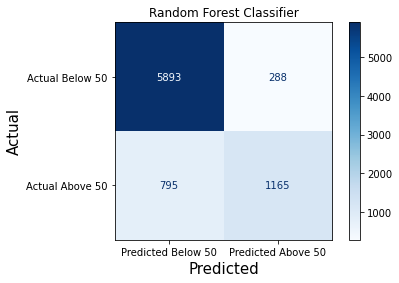

In [17]:
# Create our predictions on the test data
preds = gs.predict(X_test)

# Save confusion matrix values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Show the confusion matrix for the model.

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted',size=15)
plt.ylabel('Actual',size=15)
plt.xticks(ticks=[0,1],labels=['Predicted Below 50', 'Predicted Above 50'])
plt.yticks(ticks=[0,1],labels=['Actual Below 50', 'Actual Above 50'])
plt.savefig('images/confusion_matrix.png',format='png') # Save the figure for later use
plt.show();

## Creating the Submission

In [18]:
# Read in the test data to create a submission
test_data = pd.read_csv('data/test_data.csv')

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   sex             16281 non-null  object
 9   capital-gain    16281 non-null  int64 
 10  capital-loss    16281 non-null  int64 
 11  hours-per-week  16281 non-null  int64 
 12  native-country  16281 non-null  object
dtypes: int64(6), object(7)
memory usage: 1.6+ MB


In [20]:
# Create a function to create the features using the training criteria
def add_binary_test(df_train,df_test,header,column,threshold):
        scores = df_train.groupby(df[column]).mean()
        good_status = scores[scores['target'] > threshold].index
        df_test[header] = df_test[column].map(lambda x: 1 if x in good_status else 0)
        return print(f'Added {header} column')

In [21]:
# Processing the features of the test data
def process_test_data(df_train,df_test):
    add_binary_test(df_train,df_test,'educated','education',0.24)
    add_binary_test(df_train,df_test,'good_country','native-country',0.25)
    add_binary_test(df_train,df_test,'is_married','marital-status',0.4)
    add_binary_test(df_train,df_test,'is_spouse','relationship',0.4)
    add_binary_test(df_train,df_test,'high_class','workclass',0.25)
    add_binary_test(df_train,df_test,'good_job','occupation',0.25)
    df_test['in_market'] = np.where((df_test['capital-gain'] > 0) | (df_test['capital-loss'] > 0), 1, 0)
    df_test['has_gains'] = np.where(df_test['capital-gain'] > 0, 1, 0)
    df_test['has_losses'] = np.where(df_test['capital-loss'] > 0, 1, 0)
    df_test['over_time'] = np.where(df_test['hours-per-week'] > 40, 1, 0)
    df_test['part_time'] = np.where(df_test['hours-per-week'] < 40, 1, 0)
    df_test['higher_ed'] = np.where(df_test['education-num'] >= 13, 1, 0)
    df_test['over_20'] = np.where(df_test['age'] >= 20, 1, 0)
    df_test['over_30'] = np.where(df_test['age'] >= 30, 1, 0)
    df_test['over_40'] = np.where(df_test['age'] >= 40, 1, 0)
    df_test['over_50'] = np.where(df_test['age'] >= 50, 1, 0)
    df_test['over_60'] = np.where(df_test['age'] >= 60, 1, 0)
    df_test['over_70'] = np.where(df_test['age'] >= 70, 1, 0)
    df_test['high_gains'] = np.where(df_test['capital-gain'] > 5000, 1, 0)
    df_test['immigrant'] = np.where(df_test['native-country'] != ' United-States', 1, 0)
    return pd.get_dummies(df_test,columns=df_test.select_dtypes('object').columns,drop_first=True)

In [22]:
# Running the function to process the test data
final_test = process_test_data(df, test_data)

Added educated column
Added good_country column
Added is_married column
Added is_spouse column
Added high_class column
Added good_job column


In [23]:
# Checking the shape of the test data
final_test.shape

(16281, 115)

In [24]:
# Making sure the test data has all the required columns to be used in the model we created
missing_columns_train = list(set(X_test.columns) - set(final_test.columns))

for col in missing_columns_train:
    final_test[col] = 0
final_test = final_test[X_test.columns]

In [25]:
# Creating our submission predictions while naming the column 'wage'
submit = pd.DataFrame(gs.predict(final_test)).rename(columns={0:'wage'})

In [26]:
# Saving our submission predictions to a csv without the index saved
submit.to_csv('submission/submission.csv',index=False)

In [27]:
# Reading our submission file in check that it saved properly
checking = pd.read_csv('submission/submission.csv')
checking

,wage
0,0
1,0
2,0
3,1
4,0
...,...
16276,0
16277,0
16278,1
16279,0
